In [ ]:
!git clone https://huggingface.co/ehsanaghaei/SecureBERT



Cloning into 'SecureBERT'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 65 (delta 27), reused 20 (delta 20), pack-reused 33 (from 1)
Unpacking objects: 100% (65/65), 1.05 MiB | 3.33 MiB/s, done.
Filtering content: 100% (6/6), 1.39 GiB | 43.83 MiB/s, done.


In [ ]:
%cd /content/SecureBERT

[Errno 2] No such file or directory: '/content/SecureBERT'
/content


# New Section

# New Section

# New Section

In [ ]:
!git clone https://github.com/aptnotes/tools


Cloning into 'tools'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59 (from 1)
Receiving objects: 100% (59/59), 14.59 KiB | 498.00 KiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
!git clone https://github.com/aptnotes/data/blob/master/README.md

Cloning into 'README.md'...
fatal: repository 'https://github.com/aptnotes/data/blob/master/README.md/' not found


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


FLOW BASED MODEL FOR GEN AI


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Define a coupling layer
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.scale = nn.Linear(input_dim // 2, hidden_dim)
        self.shift = nn.Linear(input_dim // 2, hidden_dim)

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=-1)
        scale = self.scale(x1)
        shift = self.shift(x1)
        y2 = x2 * torch.exp(scale) + shift
        return torch.cat([x1, y2], dim=-1), scale

# Training the flow
def train_flow(flow_model, train_loader, optimizer, epochs):
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            z, log_det = flow_model(batch)
            loss = -torch.mean(log_det + torch.distributions.Normal(0, 1).log_prob(z))
            loss.backward()
            optimizer.step()

# Intrusion detection step
def detect_intrusion(flow_model, test_data, threshold):
    likelihoods = []
    for sample in test_data:
        z, log_det = flow_model(sample)
        likelihood = -torch.mean(log_det + torch.distributions.Normal(0, 1).log_prob(z))
        likelihoods.append(likelihood)
    return [1 if l < threshold else 0 for l in likelihoods]


In [ ]:
# Separate numeric and categorical columns
numeric_columns = dataset.select_dtypes(include=['number']).columns
categorical_columns = dataset.select_dtypes(include=['object']).columns

# Fill missing values in numeric columns with the median
dataset[numeric_columns] = dataset[numeric_columns].fillna(dataset[numeric_columns].median())

# Fill missing values in categorical columns with the mode (most frequent value)
for col in categorical_columns:
    dataset[col].fillna(dataset[col].mode()[0], inplace=True)

# Now, your dataset is cleaned and ready for further processing

<ipython-input-40-3d60b86d629e>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(dataset[col].mode()[0], inplace=True)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Coupling Layer for RealNVP
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(CouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.mask = mask

        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh(),
        )

        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x1 = x * self.mask
        s = self.scale_net(x1) * (1 - self.mask)
        t = self.translate_net(x1) * (1 - self.mask)
        y = x1 + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = torch.sum(s, dim=1)
        return y, log_det_jacobian

    def reverse(self, y):
        y1 = y * self.mask
        s = self.scale_net(y1) * (1 - self.mask)
        t = self.translate_net(y1) * (1 - self.mask)
        x = y1 + (1 - self.mask) * (y - t) * torch.exp(-s)
        return x

# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            mask = torch.tensor([i % 2] * input_dim, dtype=torch.float32)
            self.layers.append(CouplingLayer(input_dim, hidden_dim, mask))

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def reverse(self, z):
        for layer in reversed(self.layers):
            z = layer.reverse(z)
        return z

    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        log_prob_z = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.size(1) * torch.log(torch.tensor(2 * torch.pi))
        return log_prob_z + log_det_jacobian

# Training function
def train_model(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            log_prob = model.log_prob(x)
            loss = -torch.mean(log_prob)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

# Main function to load data, preprocess, and train the model
if __name__ == "__main__":
    # Configuration
    input_dim = 15  # Update based on your dataset features
    hidden_dim = 64
    num_layers = 5
    epochs = 10
    batch_size = 128
    learning_rate = 1e-3

    # Load the dataset
    dataset_path = r"/content/2022.06.14.csv"

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Coupling Layer for RealNVP
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(CouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.mask = mask

        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh(),
        )

        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x1 = x * self.mask
        s = self.scale_net(x1) * (1 - self.mask)
        t = self.translate_net(x1) * (1 - self.mask)
        y = x1 + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = torch.sum(s, dim=1)
        return y, log_det_jacobian

    def reverse(self, y):
        y1 = y * self.mask
        s = self.scale_net(y1) * (1 - self.mask)
        t = self.translate_net(y1) * (1 - self.mask)
        x = y1 + (1 - self.mask) * (y - t) * torch.exp(-s)
        return x

# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            mask = torch.tensor([i % 2] * input_dim, dtype=torch.float32)
            self.layers.append(CouplingLayer(input_dim, hidden_dim, mask))

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def reverse(self, z):
        for layer in reversed(self.layers):
            z = layer.reverse(z)
        return z

    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        log_prob_z = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.size(1) * torch.log(torch.tensor(2 * torch.pi))
        return log_prob_z + log_det_jacobian

# Training function
def train_model(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            log_prob = model.log_prob(x)
            loss = -torch.mean(log_prob)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

# Main function to load data, preprocess, and train the model
if __name__ == "__main__":
    # Configuration
    input_dim = 15  # Update based on your dataset features
    hidden_dim = 64
    num_layers = 5
    epochs = 10
    batch_size = 128
    learning_rate = 1e-3

    # Load the dataset

    dataset_path = r"/content/2022.06.14.csv"
    dataset = pd.read_csv(dataset_path)


    # Preprocess data
# Step 1: Separate numeric and non-numeric columns
    numeric_columns = dataset.select_dtypes(include=['number']).columns
    non_numeric_columns = dataset.select_dtypes(exclude=['number']).columns

# Step 2: Handle missing values
# Fill missing values in numeric columns with the median
    dataset[numeric_columns] = dataset[numeric_columns].fillna(dataset[numeric_columns].median())

# Step 3: Encode non-numeric columns
# Example: Convert the 'label' column into numeric values (e.g., 0 for benign, 1 for outlier)
    if "label" in non_numeric_columns:
        dataset["label"] = dataset["label"].map({"benign": 0, "outlier": 1})
        non_numeric_columns = non_numeric_columns.drop("label", errors="ignore")  # Remove 'label' from non-numeric list

# For other non-numeric columns, you can use one-hot encoding or label encoding
# Here's an example of label encoding:
    for col in non_numeric_columns:
        dataset[col] = dataset[col].astype('category').cat.codes

# Now the dataset is fully numeric and ready for further processing

# Assuming 'label' is the column that contains the target values (e.g., 'benign', 'outlier')
    features = dataset.drop(columns=["label"])  # Remove the 'label' column from the dataset
    labels = (dataset["label"] == "outlier").astype(int)  # Example: Label 'outlier' as 1 and others as 0

    # Normalize features
    from sklearn.preprocessing import MinMaxScaler

# Normalize the features (without the label column)
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)

# Convert the normalized features into a pandas DataFrame
    features_normalized = pd.DataFrame(features_normalized, columns=features.columns)

    # Convert to PyTorch tensors
    import torch
    from torch.utils.data import TensorDataset

# Convert features_normalized to a NumPy array before creating PyTorch tensors
    X_tensor = torch.tensor(features_normalized.values, dtype=torch.float32)  # Use .values to get the underlying NumPy array
    y_tensor = torch.tensor(labels.values, dtype=torch.float32)  # Convert labels to NumPy array

# Create a PyTorch dataset
    train_dataset = TensorDataset(X_tensor, y_tensor)

    print(f"Feature tensor shape: {X_tensor.shape}")
    print(f"Label tensor shape: {y_tensor.shape}")


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RealNVP(input_dim=X_tensor.shape[1], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, optimizer, epochs)

    # Evaluate and report anomalies
    model.eval()
    log_probs = model.log_prob(X_tensor.to(device)).detach().cpu().numpy()
    predictions = (log_probs < -20).astype(int)  # Adjust threshold as needed
    print(classification_report(labels, predictions, target_names=["Benign", "Outlier"]))
  # Replace with your local dataset file path
    dataset = pd.read_csv(r"/content/2022.06.14.csv")


    # Preprocess data
   # Assuming dataset is your DataFrame
    import pandas as pd

# Separate numeric and categorical columns
    numeric_cols = dataset.select_dtypes(include=["number"]).columns
    categorical_cols = dataset.select_dtypes(exclude=["number"]).columns

# Fill missing values for numeric columns with the median
    dataset[numeric_cols] = dataset[numeric_cols].fillna(dataset[numeric_cols].median())

# For categorical columns, fill missing values with the most frequent category
    for col in categorical_cols:
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)

# Proceed with the rest of the processing
    features = dataset.drop(columns=["label"])
    labels = (dataset["label"] == "outlier").astype(int)

# Continue with the rest of the analysis and model training


    # Normalize features
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(features_normalized, dtype=torch.float32)
    y_tensor = torch.tensor(labels.values, dtype=torch.float32)
    train_dataset = TensorDataset(X_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RealNVP(input_dim=X_tensor.shape[1], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, optimizer, epochs)

    # Evaluate and report anomalies
    model.eval()
    log_probs = model.log_prob(X_tensor.to(device)).detach().cpu().numpy()
    predictions = (log_probs < -20).astype(int)  # Adjust threshold as needed
    print(classification_report(labels, predictions, target_names=["Benign", "Outlier"]))


Feature tensor shape: torch.Size([590086, 15])
Label tensor shape: torch.Size([590086])
Epoch 1/10, Loss: -75583.1893
Epoch 2/10, Loss: -76957.8048
Epoch 3/10, Loss: -76975.6643
Epoch 4/10, Loss: -76994.6549
Epoch 5/10, Loss: -77005.1296
Epoch 6/10, Loss: -77009.5470
Epoch 7/10, Loss: -77010.4847
Epoch 8/10, Loss: -77021.1736
Epoch 9/10, Loss: -77021.2164
Epoch 10/10, Loss: -77018.5807


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Benign       1.00      0.98      0.99    590086
     Outlier       0.00      0.00      0.00         0

    accuracy                           0.98    590086
   macro avg       0.50      0.49      0.50    590086
weighted avg       1.00      0.98      0.99    590086



<ipython-input-4-a2ee200e69d9>:294: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(dataset[col].mode()[0], inplace=True)


Epoch 1/10, Loss: -75687.8631
Epoch 2/10, Loss: -76945.5425
Epoch 3/10, Loss: -76972.0554
Epoch 4/10, Loss: -76979.0134
Epoch 5/10, Loss: -76991.6526
Epoch 6/10, Loss: -76996.8534
Epoch 7/10, Loss: -77006.0428
Epoch 8/10, Loss: -76994.2216
Epoch 9/10, Loss: -77012.8051
Epoch 10/10, Loss: -77016.8364
              precision    recall  f1-score   support

      Benign       0.49      0.97      0.65    294593
     Outlier       0.01      0.00      0.00    295493

    accuracy                           0.48    590086
   macro avg       0.25      0.48      0.33    590086
weighted avg       0.25      0.48      0.33    590086



In [ ]:
# Separate numeric and categorical columns
numeric_columns = dataset.select_dtypes(include=['number']).columns
categorical_columns = dataset.select_dtypes(include=['object']).columns

# Fill missing values in numeric columns with the median
dataset[numeric_columns] = dataset[numeric_columns].fillna(dataset[numeric_columns].median())

# Fill missing values in categorical columns with the mode (most frequent value)
for col in categorical_columns:
    dataset[col].fillna(dataset[col].mode()[0], inplace=True)

# Now, your dataset is cleaned and ready for further processing


In [ ]:
from google.colab import files
uploaded = files.upload()

# To verify the uploaded file:
import os
print(os.listdir())


KeyboardInterrupt: 

In [ ]:
pip install torch numpy pandas scikit-learn matplotlib


In [ ]:
import os

dataset_path = r"/content/2022.06.14.csv"

# Check if the file exists
if os.path.exists(dataset_path):
    print("File found!")
else:
    print("File not found. Check the path.")


File found!


In [ ]:
import os
import pandas as pd

dataset_path = r"/content/2022.06.14.csv"

# Verify the file exists
if not os.path.exists(dataset_path):
    print("Error: File not found at the specified path.")
else:
    # Load the dataset
    dataset = pd.read_csv(dataset_path)
    print("Dataset loaded successfully!")
    print(dataset.head())


Dataset loaded successfully!
      avg_ipt  bytes_in  bytes_out  dest_ip  dest_port   entropy  \
0  500.000000     14280        630      786    44010.0  2.289381   
1    8.500000       329       5559      786     9200.0  4.158200   
2   30.350000     24575      27280      786     9300.0  1.766307   
3   59.000000        89        183      786      445.0  3.611253   
4  106.857143        34         29      786     5900.0  5.139898   

   num_pkts_out  num_pkts_in  proto  src_ip  src_port          time_end  \
0            30           60      6     786    9300.0  1655205565122718   
1             2            2      6     786   52136.0  1655205555212462   
2           129          117      6     786   52928.0  1655205557003075   
3             6            6      6     786   19237.0  1655193703166392   
4            11           10      6     786   47008.0  1655193704975769   

         time_start  total_entropy    label   duration  
0  1655205535093364     34134.6700   benign  30.029354

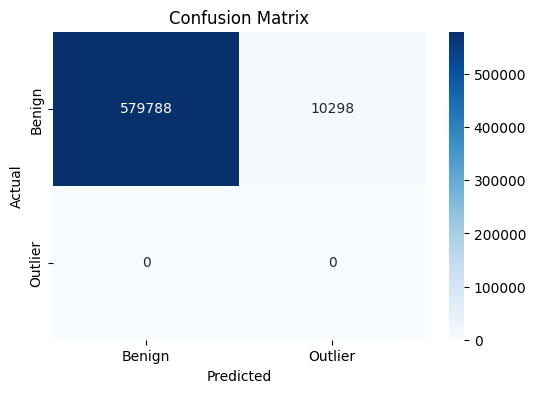

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


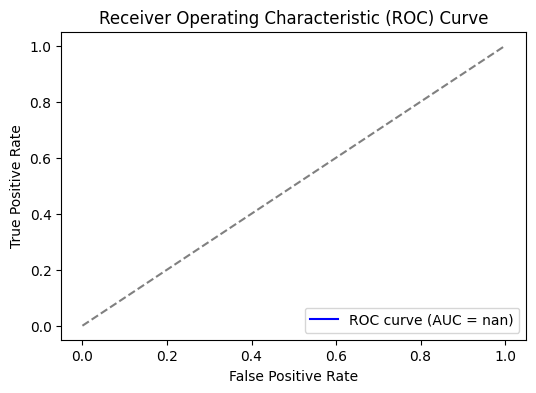

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


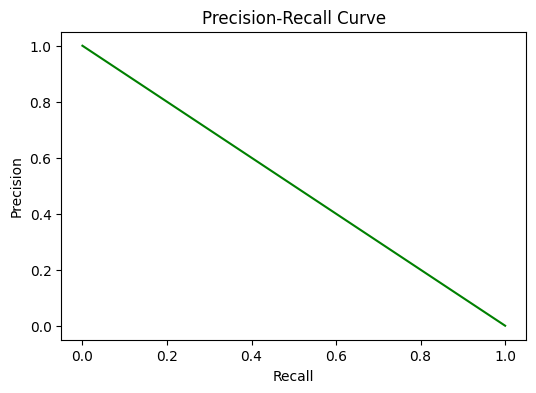

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Confusion Matrix
def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Outlier"], yticklabels=["Benign", "Outlier"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ROC Curve
def plot_roc_curve(labels, predictions):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Precision-Recall Curve
def plot_precision_recall_curve(labels, predictions):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Now call the functions to visualize
plot_confusion_matrix(labels, predictions)
plot_roc_curve(labels, predictions)
plot_precision_recall_curve(labels, predictions)


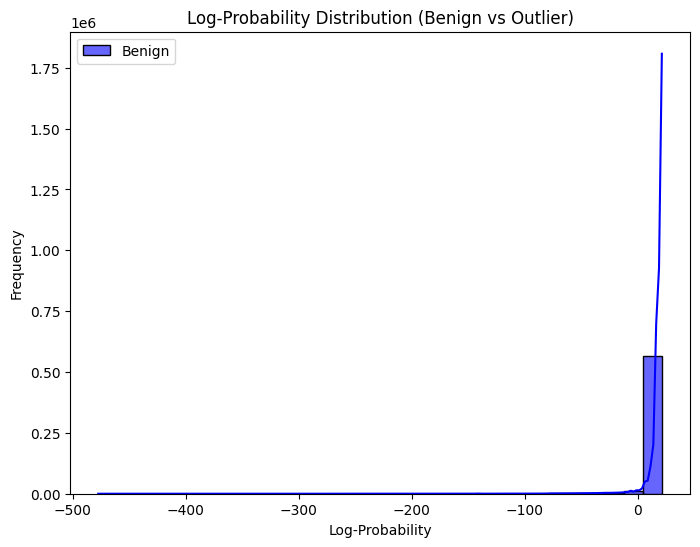

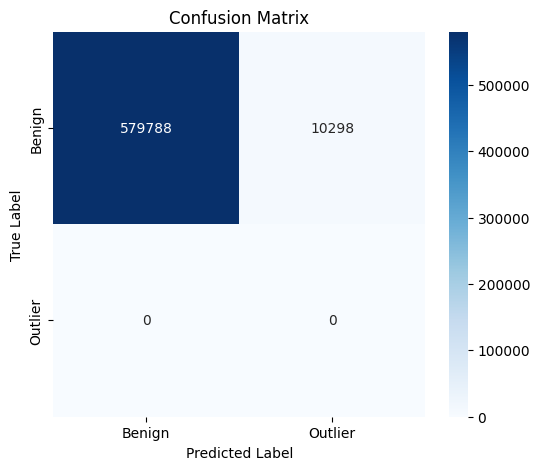

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


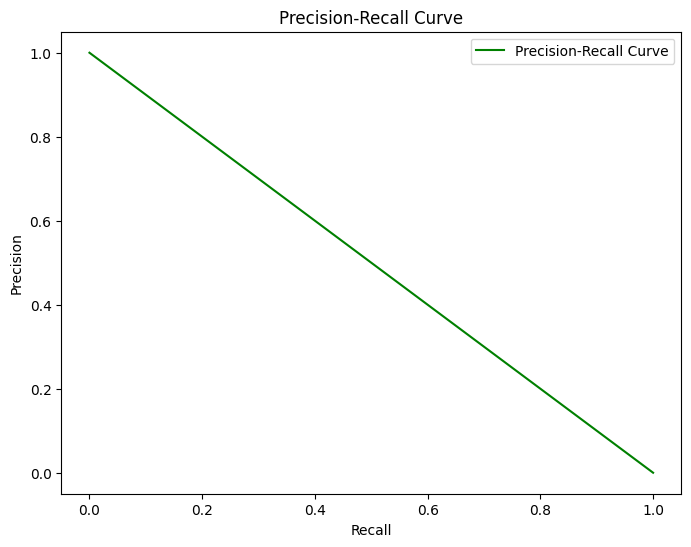

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


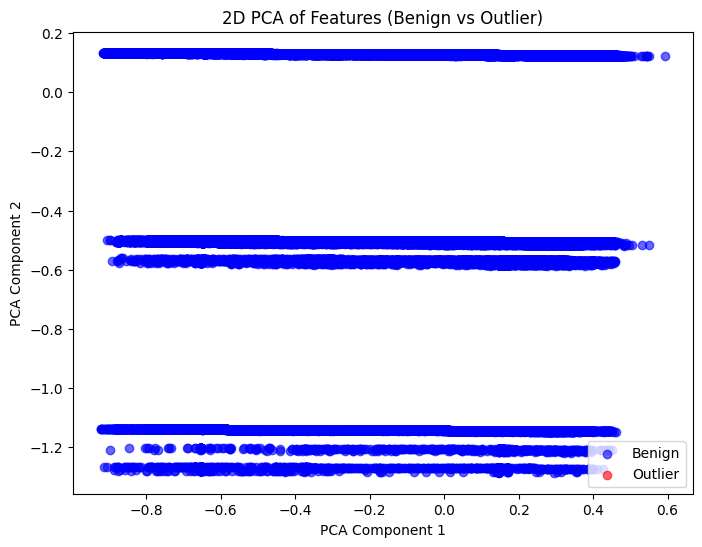

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report

# Assuming the model and the training code have been executed up to the point of predictions

# 1. Log-Probability Distribution (Benign vs Outliers)
# Assuming `log_probs` is the log-probability output of the model and `labels` contains the true class labels
plt.figure(figsize=(8, 6))
sns.histplot(log_probs[labels == 0], color="blue", kde=True, label="Benign", bins=30, alpha=0.6)
sns.histplot(log_probs[labels == 1], color="red", kde=True, label="Outlier", bins=30, alpha=0.6)
plt.xlabel("Log-Probability")
plt.ylabel("Frequency")
plt.legend()
plt.title("Log-Probability Distribution (Benign vs Outlier)")
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Outlier"], yticklabels=["Benign", "Outlier"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 3. Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(labels, -log_probs)  # Negative log_probs to match 'outlier' label
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="green", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 4. 2D Feature Visualization with PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[labels == 0, 0], features_pca[labels == 0, 1], color='blue', label='Benign', alpha=0.6)
plt.scatter(features_pca[labels == 1, 0], features_pca[labels == 1, 1], color='red', label='Outlier', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA of Features (Benign vs Outlier)")
plt.legend()
plt.show()

# 5. 2D Feature Visualization with t-SNE (Optional for better separation)
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[labels == 0, 0], features_tsne[labels == 0, 1], color='blue', label='Benign', alpha=0.6)
plt.scatter(features_tsne[labels == 1, 0], features_tsne[labels == 1, 1], color='red', label='Outlier', alpha=0.6)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("2D t-SNE of Features (Benign vs Outlier)")
plt.legend()
plt.show()



<ipython-input-7-adbfd25990ce>:114: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(dataset[col].mode()[0], inplace=True)


Epoch 1/25, Loss: -83083.2239
Epoch 2/25, Loss: -84514.7458
Epoch 3/25, Loss: -84597.9090
Epoch 4/25, Loss: -84630.6805
Epoch 5/25, Loss: -84644.3981
Epoch 6/25, Loss: -84660.5945
Epoch 7/25, Loss: -84673.9926
Epoch 8/25, Loss: -84677.6256
Epoch 9/25, Loss: -84689.8417
Epoch 10/25, Loss: -84694.9145
Epoch 11/25, Loss: -84703.4098
Epoch 12/25, Loss: -84685.8447
Epoch 13/25, Loss: -84703.7717
Epoch 14/25, Loss: -84700.7060
Epoch 15/25, Loss: -84706.5728
Epoch 16/25, Loss: -84704.8340
Epoch 17/25, Loss: -84708.5808
Epoch 18/25, Loss: -84710.2962
Epoch 19/25, Loss: -84711.4370
Epoch 20/25, Loss: -84720.0856
Epoch 21/25, Loss: -84711.5224
Epoch 22/25, Loss: -84703.6487
Epoch 23/25, Loss: -84723.4762
Epoch 24/25, Loss: -84715.4001
Epoch 25/25, Loss: -84721.1215
              precision    recall  f1-score   support

      Benign       0.56      0.56      0.56    294593
     Outlier       0.56      0.56      0.56    295493

    accuracy                           0.56    590086
   macro avg    

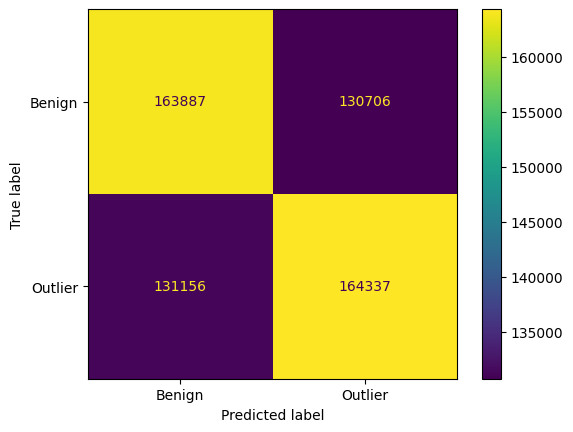

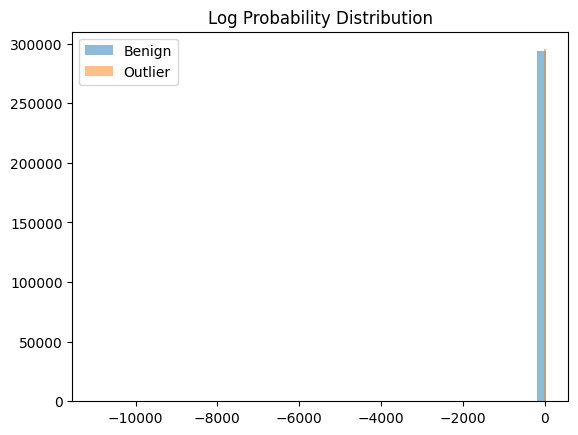

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Coupling Layer for RealNVP
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(CouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.mask = mask

        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh(),
        )

        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x1 = x * self.mask
        s = self.scale_net(x1) * (1 - self.mask)
        t = self.translate_net(x1) * (1 - self.mask)
        y = x1 + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = torch.sum(s, dim=1)
        return y, log_det_jacobian

    def reverse(self, y):
        y1 = y * self.mask
        s = self.scale_net(y1) * (1 - self.mask)
        t = self.translate_net(y1) * (1 - self.mask)
        x = y1 + (1 - self.mask) * (y - t) * torch.exp(-s)
        return x

# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            mask = torch.tensor([i % 2] * input_dim, dtype=torch.float32)
            self.layers.append(CouplingLayer(input_dim, hidden_dim, mask))

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def reverse(self, z):
        for layer in reversed(self.layers):
            z = layer.reverse(z)
        return z

    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        log_prob_z = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.size(1) * torch.log(torch.tensor(2 * torch.pi))
        return log_prob_z + log_det_jacobian

# Training function
def train_model(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            log_prob = model.log_prob(x)
            loss = -torch.mean(log_prob)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

# Main function
if __name__ == "__main__":
    # Configuration
    input_dim = 25
    hidden_dim = 75
    num_layers = 10
    epochs = 25
    batch_size = 164
    learning_rate = 1e-3

    # Load dataset
    dataset_path = r"/content/2022.06.14.csv"
    dataset = pd.read_csv(dataset_path)

    # Preprocessing
    numeric_cols = dataset.select_dtypes(include=["number"]).columns
    categorical_cols = dataset.select_dtypes(exclude=["number"]).columns

    # Fill missing values
    dataset[numeric_cols] = dataset[numeric_cols].fillna(dataset[numeric_cols].median())
    for col in categorical_cols:
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)

    # Encode labels
    dataset["label"] = dataset["label"].map({"benign": 0, "outlier": 1})
    features = dataset.drop(columns=["label"])
    labels = dataset["label"]

    # Normalize features
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)

    # Convert to tensors
    X_tensor = torch.tensor(features_normalized, dtype=torch.float32)
    y_tensor = torch.tensor(labels.values, dtype=torch.float32)
    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RealNVP(input_dim=X_tensor.shape[1], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    train_model(model, train_loader, optimizer, epochs)

    # Evaluate model
    model.eval()
    log_probs = model.log_prob(X_tensor.to(device)).detach().cpu().numpy()

    # Dynamic threshold
    threshold = np.percentile(log_probs, 50)  # 50th percentile
    predictions = (log_probs < threshold).astype(int)

    # Classification report
    print(classification_report(labels, predictions, target_names=["Benign", "Outlier"]))

    # Confusion matrix
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Outlier"])
    disp.plot()
    plt.show()

    # Visualization
    plt.hist(log_probs[labels == 0], bins=50, alpha=0.5, label='Benign')
    plt.hist(log_probs[labels == 1], bins=50, alpha=0.5, label='Outlier')
    plt.legend()
    plt.title("Log Probability Distribution")
    plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# === Dataset Loading and Preprocessing ===
def load_and_preprocess_data(dataset_path, labeled=True):
    """
    Load and preprocess the dataset.
    - For labeled data, use the 'label' column.
    - For unlabeled data, treat the entire dataset as features.
    """
    dataset = pd.read_csv(dataset_path)

    # Separate numeric and non-numeric columns
    numeric_cols = dataset.select_dtypes(include=["number"]).columns
    categorical_cols = dataset.select_dtypes(exclude=["number"]).columns

    # Fill missing values
    dataset[numeric_cols] = dataset[numeric_cols].fillna(dataset[numeric_cols].median())
    for col in categorical_cols:
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)

    # Encode non-numeric columns
    for col in categorical_cols:
        dataset[col] = dataset[col].astype('category').cat.codes

    if labeled:
        # For labeled datasets, separate features and labels
        features = dataset.drop(columns=["label"])
        labels = dataset["label"].map({"benign": 0, "outlier": 1})  # Map labels
    else:
        # For unlabeled datasets, treat all columns as features
        features = dataset
        labels = None

    # Normalize features
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    # Convert to tensors
    X_tensor = torch.tensor(features, dtype=torch.float32)
    y_tensor = torch.tensor(labels.values, dtype=torch.float32) if labeled else None

    return X_tensor, y_tensor

# === Training Function ===
def train_realnvp(model, train_loader, optimizer, epochs, alpha=0.5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            labels = batch[1].to(device) if len(batch) > 1 else None  # For labeled data
            optimizer.zero_grad()
# Fill missing values for categorical columns
for col in categorical_cols:
    # Check if mode is empty before filling
    mode_value = dataset[col].mode()
    if not mode_value.empty:
        dataset[col] = dataset[col].fillna(mode_value[0])
    else:
        dataset[col] = dataset[col].fillna('Unknown')  # Or another default value


# Define hybrid_loss
def hybrid_loss(log_probs, labels=None, alpha=0.5):
    unsupervised_loss = -log_probs.mean()  # Negative log-likelihood
    if labels is not None:
        supervised_loss = nn.BCEWithLogitsLoss()(log_probs, labels.unsqueeze(1))
        return alpha * supervised_loss + (1 - alpha) * unsupervised_loss
    else:
        return unsupervised_loss

            # Forward pass
    log_probs = model.log_prob(x)
    loss = hybrid_loss(log_probs, labels, alpha=alpha)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

# === Main Function ===
if __name__ == "__main__":
    # Configuration
    dataset_path = "/content/2022.06.14.csv"  # Update the path
    input_dim = 15  # Update based on dataset features
    hidden_dim = 64
    num_layers = 5
    epochs = 10
    batch_size = 128
    learning_rate = 1e-3
    labeled = True  # Set False for unlabeled data

    # Load dataset
   # Convert the features and labels into PyTorch tensors
    X_tensor = torch.tensor(features_normalized.values, dtype=torch.float32)
    y_tensor = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)  # Make sure labels are in the correct shape

# Create TensorDataset
    train_dataset = TensorDataset(X_tensor, y_tensor)

# Define the DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Now you can use the train_loader in your model training

    # Create DataLoader
    if labeled:
        dataset = TensorDataset(X_tensor, y_tensor)
    else:
        dataset = TensorDataset(X_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RealNVP(input_dim=X_tensor.shape[1], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_realnvp(model, train_loader, optimizer, epochs)

    # Evaluate anomalies (only applicable for labeled datasets)
    if labeled:
        model.eval()
        log_probs = model.log_prob(X_tensor.to(device)).detach().cpu().numpy()
        predictions = (log_probs < -20).astype(int)  # Adjust threshold as needed
        from sklearn.metrics import classification_report
        print(classification_report(y_tensor.numpy(), predictions, target_names=["Benign", "Outlier"]))


IndexError: too many indices for tensor of dimension 2

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Coupling Layer for RealNVP
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(CouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.mask = mask

        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh(),
        )

        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x1 = x * self.mask
        s = self.scale_net(x1) * (1 - self.mask)
        t = self.translate_net(x1) * (1 - self.mask)
        y = x1 + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = torch.sum(s, dim=1)
        return y, log_det_jacobian

    def reverse(self, y):
        y1 = y * self.mask
        s = self.scale_net(y1) * (1 - self.mask)
        t = self.translate_net(y1) * (1 - self.mask)
        x = y1 + (1 - self.mask) * (y - t) * torch.exp(-s)
        return x

# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            mask = torch.tensor([i % 2] * input_dim, dtype=torch.float32)
            self.layers.append(CouplingLayer(input_dim, hidden_dim, mask))

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def reverse(self, z):
        for layer in reversed(self.layers):
            z = layer.reverse(z)
        return z

    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        log_prob_z = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.size(1) * torch.log(torch.tensor(2 * torch.pi))
        return log_prob_z + log_det_jacobian

# Training function
def train_model(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            log_prob = model.log_prob(x)
            loss = -torch.mean(log_prob)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

# Main function
if __name__ == "__main__":
    # Configuration
    input_dim = 15
    hidden_dim = 64
    num_layers = 10
    epochs = 10
    batch_size = 150
    learning_rate = 1e-3
    labeled = True

    # Load dataset
    dataset_path = r"/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
    dataset = pd.read_csv(dataset_path)

    # Preprocessing
    numeric_cols = dataset.select_dtypes(include=["number"]).columns
    categorical_cols = dataset.select_dtypes(exclude=["number"]).columns
    def load_and_preprocess_data(dataset_path, labeled=True):


    # Fill missing values
      dataset[numeric_cols] = dataset[numeric_cols].fillna(dataset[numeric_cols].median())
    for col in categorical_cols:
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)

    # Encode labels
    if labeled:
      features = dataset.drop(columns=["label"])
      labels = dataset["label"].map({"benign": 0, "outlier": 1})
    else:
      features = dataset
      labels = None


    # Normalize features
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)

    # Convert to tensors
    X_tensor = torch.tensor(features_normalized, dtype=torch.float32)
    y_tensor = torch.tensor(labels.values, dtype=torch.float32)
    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RealNVP(input_dim=X_tensor.shape[1], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    train_model(model, train_loader, optimizer, epochs)

    # Evaluate model
    model.eval()
    log_probs = model.log_prob(X_tensor.to(device)).detach().cpu().numpy()

    # Dynamic threshold
    threshold = np.percentile(log_probs, 50)  # 50th percentile
    predictions = (log_probs < threshold).astype(int)

    # Classification report
    print(classification_report(labels, predictions, target_names=["Benign", "Outlier"]))

    # Confusion matrix
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Outlier"])
    disp.plot()
    plt.show()

    # Visualization
    plt.hist(log_probs[labels == 0], bins=50, alpha=0.5, label='Benign')
    plt.hist(log_probs[labels == 1], bins=50, alpha=0.5, label='Outlier')
    plt.legend()
    plt.title("Log Probability Distribution")
    plt.show()

<ipython-input-12-9c78de5859d5>:117: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(dataset[col].mode()[0], inplace=True)


KeyError: "['label'] not found in axis"